# Deep Reinforcement Learning — Policy Gradients — Lunar Lander

In this assignment we’ll build a Reinforcement Learning model using a Policy Gradient Network. We’ll Tensorflow to build our model and use Open AI’s Gym to measure our performance against the Lunar Lander game.

**Lunar Lander**

Here we experiment with applying the agent to the LunarLander-v2 the second environment: the LunarLander-v2. Read more about it here https://gym.openai.com/envs/LunarLander-v2/.

We use Lunar Lander, to test our model. The goal, as you can imagine, is to land on the moon! There are four discrete actions available: do nothing, fire left orientation engine, fire main engine, fire right orientation engine. The state is the coordinates and position of the lander. The reward is a combination of how close the lander is to the landing pad and how close it is to zero speed, basically the closer it is to landing the higher the reward. There are other things that affect the reward such as, firing the main engine deducts points on every frame, moving away from the landing pad deducts points, crashing deducts points, etc. This reward function is determined by the Lunar Lander environment. The game or episode ends when the lander lands, crashes, or flies off away from the screen.

## Policy Gradient Network
To approximate our policy, we’ll use a 3 layer neural network with 10 units in each of the hidden layers and 4 units in the output layer:

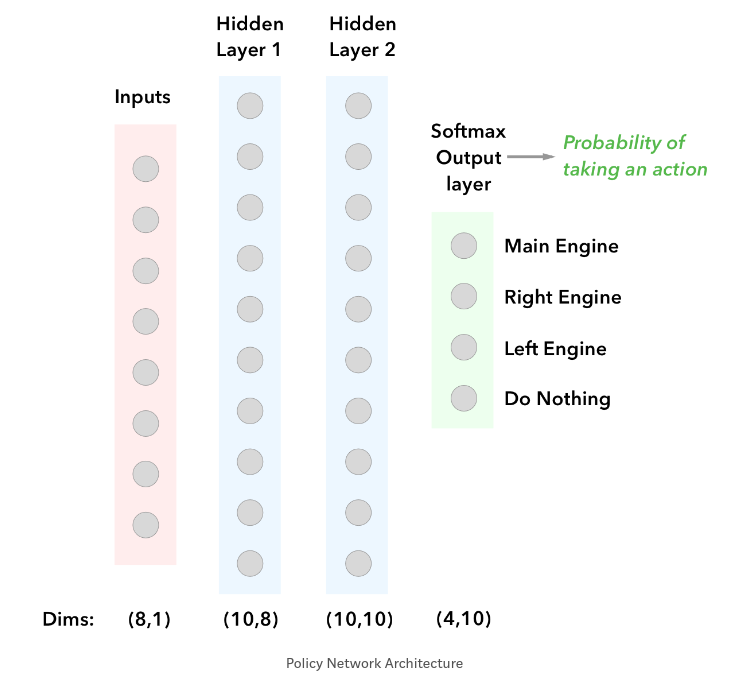

In [5]:
from IPython.display import Image, display; 
display(Image(filename='pic/PGnetwork_LunarLander.png'))

## The experience replay module.
NOTE: When we use ReplayMemory class (in Geron) instead of a deque (ExpReplay class) it is much faster for random access.

In [1]:
from collections import deque

import numpy as np


class ExpReplay():
    """
    A generic class for collecting experiences.
    """

    def __init__(self, size):
        """
        Size is the maximum number of collected experiences.
        """
        self.memory = deque(maxlen=size)

    def add(self, exp):
        """
        Add an experience to the queue.
        """
        self.memory.append(exp)

    def sample(self, size):
        """
        Method to sample a collection experiences from the memory.
        Note that this is mostly used in off-policy methods such as Q-learning.
        """
        index = np.random.choice(np.arange(len(self.memory)),
                                 size=size,
                                 replace=False)
        return [self.memory[i] for i in index]

    def get_all(self):
        """Returns all collected experiences"""
        return list(self.memory)

    def clear(self):
        """Empty the memory."""
        self.memory.clear()
        

## The entire deep reinforcement learning agent: agent.py - LunarLander-v2

#### The input vector
The input vector is the state X that we get from the Gym environment. These could be pixels or any kind of state such as coordinates and distances. The lunar Lander game gives us a vector of dimensions (8,1) for our state, and we’ll map those to the probability of taking a certain action. Four discrete actions available: do nothing, fire left orientation engine, fire main engine, fire right orientation engine.

#### Loss function to reduce variance
For our loss function we’ll use a softmax cross entropy, which gives us the negative log probability of our actions as an output. We’ll then multiply this by our reward (reward guided loss), so we can update our parameters in a way that encourages actions that lead to high rewards and discourages actions that lead to low rewards. We’ll use the Adam Optimizer to train our model.

Discounting future rewards and normalizing them (subtracting mean then dividing by standard deviation) helps to reduce variance. There are ways we could improve our loss function, by crafting a better Advantage Function. For example, add a baseline to our rewards or using methods such as the Actor Critic, which combines Policy Gradients with Deep Q-learning, would help to reduce variance. In our case, our Advantage Function is simply our discounted and normalized rewards.

#### Training
Where is the training data coming from? How do we get the logits and labels in the code? 
* Initially, we don’t have any data. for every game we play (episode) we will be saving the state, action, and reward for every step in the sequence, you can think of each of these steps as a training example. This will serve as our training data. 
* Our input vector X is the state. 
* Our logits are the outputs (before softmax) of the network and our labels are the actions we took.

#### Algorithm
We’ll play 3,000 episodes (games) total and for each episode here are the steps we follow:

* 1 - Get the state from the environment.
* 2 - Feed forward our policy network to predict the probability of each action we should take. We’ll sample from this distribution to choose which action to take (i.e. toss a biased coin).
* 3 - Receive the reward and the next state state1 from the environment for the action we took.
* 4 - Store this transition sequence of state, action, reward, for later training.
* 5 - Repeat steps 1–4. If we receive the done flag from the game it means the episode is over.
* 6 - Once the episode is over, we train our neural network to learn from our stored transitions using our **reward guided loss function**.
* 7 - Play next episode and repeat steps above! Eventually our agent will get good at the game and start getting some high scores.

#### Results
Initially the agent is not very good at landing, it’s basically taking random actions !

After several hundred episodes the agent starts to learn how to fly!

Eventually after about 3 thousand episodes, the agent learns how to land in the landing zone!

In [6]:
from collections import deque

import tensorflow as tf
import numpy as np
from random import shuffle

#from .expreplay import ExpReplay


class Agent():
    """
    The agent class where you should implement the vanilla policy gradient agent.
    """
    
    def __init__(self, tf_session, state_size=(8,), action_size=4,
                 learning_rate=1e-3, gamma=0.99, memory_size=5000):
        """
        The initialization function. Besides saving attributes we also need
        to create the policy network in Tensorflow that later will be used.
        """
        # 1. Specify the network architecture
        self.state_size = state_size    # == env.observation_space.shape[0]
        self.n_outputs = action_size    # outputs the probability of accelerating left and right
        n_hidden = 10                   # it's a simple task, we don't need more than this
        n_inputs = 8
        
        # A Session object encapsulates the environment in which
        # Tensor objects are evaluated
        self.tf_sess = tf_session
        
        self.gamma = gamma
        self.replay = ExpReplay(memory_size)
        
        # variables initialization
        #initializer = tf.contrib.layers.variance_scaling_initializer()
        initializer = tf.variance_scaling_initializer()
        #initializer = tf.global_variables_initializer()


        # 2. Build the neural network in TensorFlow
        with tf.variable_scope('agent'):
                       
            # Create tf.placeholder variables, i.e. inputs into the neural network graph.
            # tf.placeholder variables are dummy nodes that provide entry points 
            # for data to computational graph).
            self.X = tf.placeholder(tf.float32, shape=[None, n_inputs])
            
            self.reward = tf.placeholder(tf.float32, shape=(None,))
            
            self.action = tf.placeholder(tf.int32, shape=(None,))
            
            # Create the hidden layers
            hidden = tf.layers.dense(self.X, n_hidden, activation=tf.nn.elu,
                         kernel_initializer=initializer)
            hidden2 = tf.layers.dense(hidden, n_hidden, activation=tf.nn.elu,
                         kernel_initializer=initializer)
            
            logits = tf.layers.dense(hidden2, self.n_outputs, activation=None)
            
            # create the output
            # use the SoftMax activation function to model the probability for each action
            self.outputs = tf.nn.softmax(logits)
            
            # 3. Select a random action based on the estimated probabilities. TO DO XXXX
            #self.action = tf.add(multinomial(tf.log(self.outputs), num_samples=2))   
            
            # define the cost function (cross entropy) and compute the gradients:
            cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=tf.one_hot(self.action, 
                                                                                      depth=self.n_outputs), 
                                                                    logits=logits)
            
            # Create the loss. We need to multiply the reward with the
            # log-probability of the selected actions.
            loss = tf.reduce_mean(self.reward * cross_entropy)

            # Create the optimizer to minimize the loss
            self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)

            #pass

        # All variables are run after the model being fully constructed
        tf_session.run(tf.global_variables_initializer())
        #saver = tf.train.Saver()

    """
    take_action() that samples the action from the policy network. 
    Run the training and see that it works and acts randomly.
    """
    def take_action(self, state):
        """
        Given the current state, sample an action from the policy network.
        Return a the index of the action [0..N).
        """
        
        # A feed_dict is a python dictionary mapping from tf.placeholder variables 
        # (or their names) to data (numpy arrays, lists, etc.).
        
        # here use the SoftMax activation function to model the
        # probability for each action (outputs), see the network above
        action_pred = self.tf_sess.run(self.outputs, 
                                        feed_dict={self.X: [state]})[0]
        
        # We then randomly sample an action based on the estimated probability given by the SoftMax.
        action = np.random.choice(range(self.n_outputs), p=action_pred)
       
        #action = np.random.choice(range(self.action_size))
        return action

    """
    record_action() that just saves a taken action and its reward
    """
    def record_action(self, state0, action, reward, state1, done):
        """
        Record an action taken by the action and the associated reward
        and next state. This will later be used for traning.
        """
        self.replay.add((action, reward, state0))
        #self.replay.add((action, reward, state1))
        
        #pass

    """
    train_agent() that takes the experiences (states, actions, and rewards) 
    collected in record_action() and sends them through the network to compute 
    and optimize the loss.

    """
    def train_agent(self):
        """
        Train the policy network using the collected experiences during the
        episode(s).
        """
        # Retrieve collected experiences from memory
        collected_experiences = self.replay.get_all()
        
        # XXXX Refresh the memory
        self.replay.clear()                               
        
        actions = [h[0] for h in collected_experiences]
        rewards = [h[1] for h in collected_experiences]
        states = [h[2] for h in collected_experiences]

        # Discount and normalize rewards
        rewards = self.discount_rewards_and_normalize(rewards)

        # Shuffle for better learning
        # shuffle(collected_experiences)

        # Feed the experiences through the network with rewards to compute and
        # minimize the loss.
        # In tensorFlow, we supplement the values to placeholders using
        # a python dictionary feed_dict
        output = self.tf_sess.run(self.optimizer, 
                                  feed_dict={self.action: actions,
                                             self.reward: rewards, 
                                             self.X: states})
        #output = self.tf_sess.run(self.optimizer, 
         #                         feed_dict={self.reward: rewards})
        #pass

    """
    We need to compute the total discounted rewards,
    given the raw rewards, and to normalize the results across multiple episodes:
    """
    def discount_rewards(self, rewards, discount_rate):
        
        # Given the rewards for an epsiode discount them by gamma.
        discounted_rewards = np.zeros(len(rewards))
        cumulative_rewards = 0
        
        for step in reversed(range(len(rewards))):
            cumulative_rewards = rewards[step] + cumulative_rewards * discount_rate
            discounted_rewards[step] = cumulative_rewards
        return discounted_rewards
    
    def discount_rewards_and_normalize(self, rewards):
        # Next since we are sending them into the neural network they should
        # have a zero mean and unit variance.
        dis_rewards = self.discount_rewards(rewards, self.gamma)
        
        reward_mean = dis_rewards.mean()
        reward_std = dis_rewards.std()
        
        # Return the new discounted and normalized rewards.
        return (dis_rewards - reward_mean)/ reward_std 
        #return ((dis_rewards - reward_mean)/reward_std) 
        
        # pass

## Main - Environment LunarLander-v2

In [8]:
from time import time

import gym
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

#from .agent import Agent


def env_solved(history):
    """
    Checks if the agent has solved the CartPole-v1 environment.
    """
    return history[-1]['mean_reward'] >= 450


def main(nbr_eps, tf_session, render_every=100):
    """Main training loop of the RL agent."""

    # Create the environment
    env = gym.make('LunarLander-v2')
    env.seed(1)

    # Create the agent
    agent = Agent(tf_session,
                  state_size=env.observation_space.shape,
                  action_size=env.action_space.n,
                  learning_rate=1e-2,
                  gamma=0.99)
    
    history = []
    
    
    ####  Evaluating the performance ot our agent
    for episode in range(1, nbr_eps + 1):
        
        # Start an episode of training
        # After the environment is created, 
        # we must initialize it using the reset() method
        state0 = env.reset()
        
        # done: This value will be True when the episode is over.
        done = False
        step = 0
        total_reward = 0
        tt = time()

        # Take actions until the end of the episode
        while not done:

            # Render every nth episode
            # the render() method displays the environment
            if episode % render_every == 0:
                env.render()

            # Ask agent for action
            action = agent.take_action(state0)

            # Apply action to the environment. Get reward and the new state.
            state1, reward, done, _ = env.step(action)

            # Memorizing: Record the <s, a, r, s'> tuple for later when training.
            agent.record_action(state0, action, reward, state1, done)

            total_reward += reward
            step += 1
            state0 = state1

        
        # Train the network after each episode
        agent.train_agent()

        # Save information about the episode
        mean_reward = np.mean(np.array([h['reward'] for h in history[-100:]])) \
            if len(history) > 0 else 0
        
        history.append({
            'episode': episode, 'reward': total_reward, 'steps': step, 'time': time() - tt,
            'mean_reward': mean_reward
        })
        
        # Print information about the episode
        print('Information about the episode: \n', 
              episode, total_reward, step, "%.2f" % mean_reward)

        if env_solved(history):
            print('Agent solved the environment in {} episodes!'.format(episode))
            plt.plot([h['mean_reward'] for h in history])
            plt.ylabel('Mean reward')
            plt.xlabel('Episode')
            plt.show()
            break


if __name__ == '__main__':
    tf.reset_default_graph()
    with tf.Session() as tf_session:
        main(3000, tf_session)
        

Information about the episode: 
 1 -376.15425120800484 55 0.00
Information about the episode: 
 2 -559.5902348275839 65 -376.15
Information about the episode: 
 3 -147.76875122753734 58 -467.87
Information about the episode: 
 4 -481.6327051249509 97 -361.17
Information about the episode: 
 5 -376.2468921699682 59 -391.29
Information about the episode: 
 6 -198.0974419664315 63 -388.28
Information about the episode: 
 7 -298.19265380593475 75 -356.58
Information about the episode: 
 8 -508.05353428723026 81 -348.24
Information about the episode: 
 9 -217.06981626266406 57 -368.22
Information about the episode: 
 10 -314.4103755223211 65 -351.42
Information about the episode: 
 11 -235.10578540945681 65 -347.72
Information about the episode: 
 12 -241.09742914893178 75 -337.48
Information about the episode: 
 13 -257.2901625913768 65 -329.45
Information about the episode: 
 14 -311.8682349734387 73 -323.90
Information about the episode: 
 15 -282.39069934879234 59 -323.04
Information ab

Information about the episode: 
 124 -375.27150465201856 110 -417.28
Information about the episode: 
 125 -65.86359200640857 78 -416.77
Information about the episode: 
 126 -297.2629960779447 86 -414.12
Information about the episode: 
 127 -27.096945572174207 143 -416.26
Information about the episode: 
 128 -62.38416957838119 81 -415.69
Information about the episode: 
 129 -233.43930134587035 161 -414.75
Information about the episode: 
 130 -66.3295367884255 63 -414.98
Information about the episode: 
 131 -156.50785805026248 117 -414.38
Information about the episode: 
 132 -187.02758020811874 79 -411.67
Information about the episode: 
 133 -170.66309014661812 110 -410.51
Information about the episode: 
 134 -178.6918207030958 117 -410.90
Information about the episode: 
 135 -105.48758864677085 75 -410.87
Information about the episode: 
 136 -118.99768318459081 112 -411.16
Information about the episode: 
 137 -169.8907661620376 117 -412.01
Information about the episode: 
 138 -145.59940

Information about the episode: 
 247 -197.30047113048118 218 -133.60
Information about the episode: 
 248 -152.41324619576466 110 -133.77
Information about the episode: 
 249 -289.90068534257193 121 -134.91
Information about the episode: 
 250 -161.49742957556754 171 -134.20
Information about the episode: 
 251 -286.1469220845599 333 -135.47
Information about the episode: 
 252 -265.56152713957226 213 -134.80
Information about the episode: 
 253 -143.51135886248218 158 -135.21
Information about the episode: 
 254 -216.38950578721108 244 -133.42
Information about the episode: 
 255 -182.65016832791673 192 -133.48
Information about the episode: 
 256 -152.88941517948086 162 -134.47
Information about the episode: 
 257 -178.8842465878678 312 -135.35
Information about the episode: 
 258 -46.886698328179065 186 -136.06
Information about the episode: 
 259 -137.32814304444736 205 -133.85
Information about the episode: 
 260 -28.797270348899772 222 -133.55
Information about the episode: 
 261

Information about the episode: 
 367 -27.839457181099473 1000 -120.01
Information about the episode: 
 368 -25.908375442100787 1000 -120.10
Information about the episode: 
 369 13.286393792562254 1000 -118.75
Information about the episode: 
 370 -42.95746356195909 1000 -116.05
Information about the episode: 
 371 5.594772497335612 115 -116.21
Information about the episode: 
 372 -22.428905989160455 1000 -115.75
Information about the episode: 
 373 -28.283636599473397 98 -113.98
Information about the episode: 
 374 52.461634213799044 151 -111.69
Information about the episode: 
 375 -17.036906721133384 1000 -109.04
Information about the episode: 
 376 -31.656949050885146 1000 -107.55
Information about the episode: 
 377 -141.94956661653788 1000 -105.92
Information about the episode: 
 378 -104.74821241652705 1000 -106.79
Information about the episode: 
 379 -43.27108350638947 1000 -106.82
Information about the episode: 
 380 -72.58705299366405 1000 -107.07
Information about the episode: 

Information about the episode: 
 489 -0.5656584417070454 1000 -50.88
Information about the episode: 
 490 -12.03684102006756 1000 -50.94
Information about the episode: 
 491 -71.34586179582067 1000 -50.41
Information about the episode: 
 492 -34.200397550868 1000 -51.13
Information about the episode: 
 493 -36.707378706486494 1000 -50.74
Information about the episode: 
 494 -75.75023787781166 1000 -51.30
Information about the episode: 
 495 12.713749332541386 1000 -51.08
Information about the episode: 
 496 -43.356526853290106 1000 -50.68
Information about the episode: 
 497 -39.54431003895776 1000 -51.11
Information about the episode: 
 498 -22.695312478854547 207 -51.08
Information about the episode: 
 499 13.408491479106978 1000 -51.05
Information about the episode: 
 500 -159.57377569660437 261 -50.83
Information about the episode: 
 501 -65.40069234446145 1000 -52.08
Information about the episode: 
 502 -43.55769618624456 1000 -52.32
Information about the episode: 
 503 -16.839619

Information about the episode: 
 610 4.146607850790087 1000 -32.27
Information about the episode: 
 611 16.02236656575444 1000 -32.43
Information about the episode: 
 612 -71.92048784015377 1000 -31.51
Information about the episode: 
 613 23.511359962091355 1000 -32.32
Information about the episode: 
 614 -11.067501312452725 1000 -31.38
Information about the episode: 
 615 -13.051633745983942 1000 -30.92
Information about the episode: 
 616 -39.05732922766643 1000 -30.35
Information about the episode: 
 617 41.047662416196516 1000 -30.81
Information about the episode: 
 618 -2.1466674254005627 1000 -30.24
Information about the episode: 
 619 -5.702938984425558 268 -29.66
Information about the episode: 
 620 33.21138427951091 1000 -29.61
Information about the episode: 
 621 3.144159061440054 1000 -29.48
Information about the episode: 
 622 23.949776781509136 1000 -29.74
Information about the episode: 
 623 31.873666843732124 1000 -27.80
Information about the episode: 
 624 44.8067369262

Information about the episode: 
 732 60.527434906630795 1000 -38.15
Information about the episode: 
 733 -145.60074855345272 463 -37.55
Information about the episode: 
 734 28.748589466984455 1000 -39.02
Information about the episode: 
 735 -47.66924296931434 1000 -38.38
Information about the episode: 
 736 72.1099710212479 204 -38.91
Information about the episode: 
 737 54.48756277954491 1000 -38.30
Information about the episode: 
 738 72.27298190097493 1000 -38.13
Information about the episode: 
 739 34.668938962670445 1000 -37.29
Information about the episode: 
 740 75.0915288113032 1000 -36.98
Information about the episode: 
 741 51.38815806111535 1000 -36.75
Information about the episode: 
 742 71.62921505506553 1000 -36.49
Information about the episode: 
 743 3.7980038260332645 1000 -35.43
Information about the episode: 
 744 33.160487058314835 1000 -34.20
Information about the episode: 
 745 18.52734289292082 1000 -33.96
Information about the episode: 
 746 64.38669340381216 100

Information about the episode: 
 856 152.58137169722798 780 27.65
Information about the episode: 
 857 101.28007991304696 1000 28.12
Information about the episode: 
 858 -7.524470145085317 253 28.62
Information about the episode: 
 859 -26.850833226313853 293 27.96
Information about the episode: 
 860 217.20246705912592 324 26.93
Information about the episode: 
 861 -7.28001966229329 1000 29.46
Information about the episode: 
 862 211.1684954687862 362 29.83
Information about the episode: 
 863 -29.734964718760978 307 32.07
Information about the episode: 
 864 102.58708056860449 1000 30.95
Information about the episode: 
 865 25.94716949542388 326 31.11
Information about the episode: 
 866 108.82469988321918 1000 31.06
Information about the episode: 
 867 135.2945428897763 1000 33.06
Information about the episode: 
 868 196.8872534278561 437 34.50
Information about the episode: 
 869 224.77622466996678 630 36.29
Information about the episode: 
 870 -57.696644070335736 289 38.36
Informa

Information about the episode: 
 980 -42.329075696297174 1000 114.69
Information about the episode: 
 981 -39.97489899689787 1000 111.48
Information about the episode: 
 982 -45.41103212979096 1000 110.69
Information about the episode: 
 983 -50.700971335769026 1000 109.38
Information about the episode: 
 984 -32.47889621782342 1000 106.18
Information about the episode: 
 985 19.25390098219532 1000 105.50
Information about the episode: 
 986 -62.192792201295326 1000 103.64
Information about the episode: 
 987 -131.36804756665794 796 101.69
Information about the episode: 
 988 -113.724871002689 715 99.20
Information about the episode: 
 989 -20.407864846346 1000 96.87
Information about the episode: 
 990 -1.0514910718819592 1000 96.12
Information about the episode: 
 991 -55.04246166654344 1000 95.29
Information about the episode: 
 992 27.33750411080322 1000 92.81
Information about the episode: 
 993 -34.08620498225763 1000 90.19
Information about the episode: 
 994 3.128156458461012 1

Information about the episode: 
 1102 142.13317818377382 1000 159.75
Information about the episode: 
 1103 108.94630760360211 1000 158.96
Information about the episode: 
 1104 223.7924860691299 220 157.90
Information about the episode: 
 1105 80.94960788809728 1000 159.37
Information about the episode: 
 1106 5.5830401765559685 149 158.43
Information about the episode: 
 1107 -23.12677339889204 165 156.15
Information about the episode: 
 1108 106.4533505743757 1000 154.18
Information about the episode: 
 1109 193.51543433521198 676 155.66
Information about the episode: 
 1110 129.41891403144098 1000 155.90
Information about the episode: 
 1111 40.37080094422683 160 155.06
Information about the episode: 
 1112 126.70903981055093 1000 153.55
Information about the episode: 
 1113 0.24276405977872173 167 155.33
Information about the episode: 
 1114 162.8594207899694 1000 153.02
Information about the episode: 
 1115 230.95578739363353 270 153.55
Information about the episode: 
 1116 -57.212

Information about the episode: 
 1223 89.95436518701034 1000 22.25
Information about the episode: 
 1224 -46.04499264250106 1000 21.09
Information about the episode: 
 1225 130.2496146964205 858 20.64
Information about the episode: 
 1226 -34.26529180366606 160 22.24
Information about the episode: 
 1227 28.75069557013309 1000 22.29
Information about the episode: 
 1228 151.5266991753272 443 23.21
Information about the episode: 
 1229 56.933980302549 1000 25.56
Information about the episode: 
 1230 204.50338953225463 425 24.14
Information about the episode: 
 1231 114.99492180645372 1000 27.27
Information about the episode: 
 1232 -42.82945677258465 178 26.41
Information about the episode: 
 1233 89.57374295814407 1000 26.84
Information about the episode: 
 1234 47.39809868289983 1000 26.11
Information about the episode: 
 1235 122.67945865594712 1000 27.34
Information about the episode: 
 1236 248.6976792039021 219 29.02
Information about the episode: 
 1237 37.2831528355446 1000 31.5

Information about the episode: 
 1346 -123.56546081565969 74 25.65
Information about the episode: 
 1347 240.20855866444506 324 22.34
Information about the episode: 
 1348 -117.22724214918648 88 24.98
Information about the episode: 
 1349 18.031733652728562 81 24.28
Information about the episode: 
 1350 22.394744748996132 70 24.32
Information about the episode: 
 1351 16.760067980166312 87 24.96
Information about the episode: 
 1352 -79.90649757132579 104 25.42
Information about the episode: 
 1353 221.27699031202877 252 24.66
Information about the episode: 
 1354 -187.60435055345607 78 26.90
Information about the episode: 
 1355 -234.01087073607786 69 25.55
Information about the episode: 
 1356 -109.72403237846777 73 22.65
Information about the episode: 
 1357 -197.6531156666657 94 22.04
Information about the episode: 
 1358 -178.3869989114295 76 19.86
Information about the episode: 
 1359 -157.2905176299754 56 17.52
Information about the episode: 
 1360 -16.0369678111162 211 14.40
In

Information about the episode: 
 1469 30.381713583722217 139 -24.46
Information about the episode: 
 1470 -14.008988298706711 96 -24.04
Information about the episode: 
 1471 -31.465183306122185 108 -25.57
Information about the episode: 
 1472 31.218044013308315 121 -24.04
Information about the episode: 
 1473 3.868694790663568 85 -22.21
Information about the episode: 
 1474 75.91468754767672 100 -24.23
Information about the episode: 
 1475 40.707778782574906 176 -21.02
Information about the episode: 
 1476 47.76588311213189 185 -20.07
Information about the episode: 
 1477 36.22592630697173 76 -19.06
Information about the episode: 
 1478 19.81512616671118 90 -20.73
Information about the episode: 
 1479 17.614637470486883 159 -19.60
Information about the episode: 
 1480 60.99408440176816 95 -18.37
Information about the episode: 
 1481 -28.07437755077143 77 -17.88
Information about the episode: 
 1482 134.79057463462223 502 -16.53
Information about the episode: 
 1483 0.7184208198391957 8

Information about the episode: 
 1592 152.40347910899675 492 59.42
Information about the episode: 
 1593 -246.42324259352486 132 60.61
Information about the episode: 
 1594 222.53276379683467 501 58.61
Information about the episode: 
 1595 -68.52663845558618 164 60.52
Information about the episode: 
 1596 57.953167711076645 202 59.10
Information about the episode: 
 1597 155.64071752412832 407 59.71
Information about the episode: 
 1598 260.02584289868093 362 61.05
Information about the episode: 
 1599 142.5260650541078 468 64.22
Information about the episode: 
 1600 25.827629571640102 168 65.41
Information about the episode: 
 1601 214.68750773364422 690 65.09
Information about the episode: 
 1602 10.696668299350193 137 66.77
Information about the episode: 
 1603 269.2357919811618 425 67.15
Information about the episode: 
 1604 239.77452013884636 385 69.78
Information about the episode: 
 1605 101.18350832210282 1000 72.53
Information about the episode: 
 1606 38.87724235301749 161 73

Information about the episode: 
 1714 229.90745684970523 300 111.56
Information about the episode: 
 1715 -53.660812834961035 132 113.73
Information about the episode: 
 1716 193.447041022689 295 112.99
Information about the episode: 
 1717 -12.45538233202867 1000 114.39
Information about the episode: 
 1718 -270.7175613278316 102 112.44
Information about the episode: 
 1719 -80.02049727042616 168 109.83
Information about the episode: 
 1720 -57.78074697923243 1000 106.20
Information about the episode: 
 1721 262.53927512323344 197 105.64
Information about the episode: 
 1722 -171.5028567949836 142 107.92
Information about the episode: 
 1723 14.602617259026957 89 105.09
Information about the episode: 
 1724 -58.85904127136627 348 104.72
Information about the episode: 
 1725 -233.28361485258435 74 102.90
Information about the episode: 
 1726 244.12849479612203 267 100.01
Information about the episode: 
 1727 42.66076491148908 103 101.26
Information about the episode: 
 1728 -74.2465187

Information about the episode: 
 1840 18.188417927531233 69 13.60
Information about the episode: 
 1841 29.08812779708697 76 14.90
Information about the episode: 
 1842 14.0642952928563 72 15.38
Information about the episode: 
 1843 4.73108568847114 78 15.94
Information about the episode: 
 1844 7.958741641349405 106 15.87
Information about the episode: 
 1845 -34.87912078060654 67 15.89
Information about the episode: 
 1846 19.143164597554986 76 15.91
Information about the episode: 
 1847 -14.982179623048737 121 15.86
Information about the episode: 
 1848 -36.51974270010736 111 16.09
Information about the episode: 
 1849 -45.12791202967844 120 15.63
Information about the episode: 
 1850 -44.80469816772225 129 15.79
Information about the episode: 
 1851 -15.978574597487736 90 15.48
Information about the episode: 
 1852 -5.897413098208915 106 15.11
Information about the episode: 
 1853 -13.174705077250053 64 15.21
Information about the episode: 
 1854 -34.21279120294726 123 15.36
Inform

Information about the episode: 
 1966 -244.60017606601932 101 -46.06
Information about the episode: 
 1967 -125.91592652403581 72 -48.06
Information about the episode: 
 1968 -181.85361796526803 94 -49.05
Information about the episode: 
 1969 -126.78453456903854 70 -50.52
Information about the episode: 
 1970 -68.42206048331008 54 -51.51
Information about the episode: 
 1971 -139.24611286310312 66 -51.93
Information about the episode: 
 1972 -76.02716254820804 56 -52.62
Information about the episode: 
 1973 -99.46091638405537 56 -53.05
Information about the episode: 
 1974 -80.10639821367836 76 -53.94
Information about the episode: 
 1975 -79.62591861388867 56 -55.06
Information about the episode: 
 1976 -74.09046138001403 62 -55.55
Information about the episode: 
 1977 -73.28270826951653 55 -56.22
Information about the episode: 
 1978 -110.38372186832922 71 -56.78
Information about the episode: 
 1979 -102.09667671060282 84 -57.41
Information about the episode: 
 1980 -109.48636980273

Information about the episode: 
 2089 -50.2060780977616 75 -45.52
Information about the episode: 
 2090 -24.334080910565334 76 -45.07
Information about the episode: 
 2091 -57.36981841949829 78 -44.40
Information about the episode: 
 2092 -1.7666847984873613 163 -42.98
Information about the episode: 
 2093 -23.605243919417205 88 -42.07
Information about the episode: 
 2094 -53.76113467477411 91 -41.24
Information about the episode: 
 2095 -42.248564800345946 84 -40.85
Information about the episode: 
 2096 -38.11466854920006 74 -40.76
Information about the episode: 
 2097 -53.00442239952912 70 -40.49
Information about the episode: 
 2098 -19.42045944263569 60 -40.12
Information about the episode: 
 2099 -38.1606509297566 79 -39.50
Information about the episode: 
 2100 -33.441574751257335 72 -39.39
Information about the episode: 
 2101 -45.321677460795 56 -39.13
Information about the episode: 
 2102 -12.738147883949026 78 -38.01
Information about the episode: 
 2103 -10.898430755143437 8

Information about the episode: 
 2211 -68.89110653967005 69 -46.57
Information about the episode: 
 2212 -89.2811398162511 73 -46.92
Information about the episode: 
 2213 -54.505260260036096 55 -47.76
Information about the episode: 
 2214 -54.762150639998254 104 -48.26
Information about the episode: 
 2215 -48.22838699869072 61 -48.42
Information about the episode: 
 2216 -67.42260754865204 66 -48.75
Information about the episode: 
 2217 -62.37838113291583 71 -49.72
Information about the episode: 
 2218 -58.02987540006113 92 -49.97
Information about the episode: 
 2219 -72.26322707251558 87 -49.96
Information about the episode: 
 2220 -65.00316821563607 89 -50.49
Information about the episode: 
 2221 -56.98985259971849 85 -50.80
Information about the episode: 
 2222 -100.38388781409884 73 -50.89
Information about the episode: 
 2223 -110.3064617894379 69 -51.82
Information about the episode: 
 2224 -57.95308523345903 74 -52.62
Information about the episode: 
 2225 -82.12519897709613 73

Information about the episode: 
 2334 -243.60491751558928 335 -43.23
Information about the episode: 
 2335 -195.4422715167176 86 -45.34
Information about the episode: 
 2336 -23.198818018280065 123 -46.59
Information about the episode: 
 2337 -151.1232993064927 72 -46.14
Information about the episode: 
 2338 -217.81552904866749 82 -46.08
Information about the episode: 
 2339 -288.0881476077018 94 -47.83
Information about the episode: 
 2340 -147.71813146111526 69 -50.19
Information about the episode: 
 2341 -170.0091018624628 70 -51.16
Information about the episode: 
 2342 -154.9470990132943 79 -52.19
Information about the episode: 
 2343 10.24824582117958 126 -53.25
Information about the episode: 
 2344 -41.2869291077901 78 -52.47
Information about the episode: 
 2345 -147.97204252252592 71 -52.24
Information about the episode: 
 2346 13.985168015140289 83 -53.24
Information about the episode: 
 2347 -64.39683346405113 66 -52.05
Information about the episode: 
 2348 -4.409071188934945

Information about the episode: 
 2457 172.21863318681022 680 -18.31
Information about the episode: 
 2458 14.972471885732816 97 -14.61
Information about the episode: 
 2459 -21.21596751839496 99 -14.12
Information about the episode: 
 2460 -52.47927347221591 74 -14.34
Information about the episode: 
 2461 -62.942384922897574 84 -13.70
Information about the episode: 
 2462 6.313586135799355 119 -14.61
Information about the episode: 
 2463 -20.473457688699213 73 -14.79
Information about the episode: 
 2464 -107.46893234116587 58 -14.79
Information about the episode: 
 2465 196.75054613774068 356 -15.13
Information about the episode: 
 2466 214.43949083787027 458 -11.87
Information about the episode: 
 2467 25.664737688852682 110 -8.81
Information about the episode: 
 2468 48.90447218286241 1000 -8.42
Information about the episode: 
 2469 228.6039126033111 428 -6.66
Information about the episode: 
 2470 4.458695376705776 125 -3.13
Information about the episode: 
 2471 219.60009827901303 3

Information about the episode: 
 2582 11.121162151371948 92 -43.85
Information about the episode: 
 2583 -20.53588608914501 59 -45.27
Information about the episode: 
 2584 -81.76579563649537 61 -44.40
Information about the episode: 
 2585 -12.763268048945974 65 -44.14
Information about the episode: 
 2586 -178.45648638757115 84 -46.50
Information about the episode: 
 2587 -332.6669290650725 98 -46.14
Information about the episode: 
 2588 16.648396015150865 75 -49.74
Information about the episode: 
 2589 23.877038946783912 100 -48.48
Information about the episode: 
 2590 -281.6116778757744 105 -48.31
Information about the episode: 
 2591 1.731492366128208 99 -51.16
Information about the episode: 
 2592 11.514240033325294 63 -50.17
Information about the episode: 
 2593 -83.90953264829945 84 -50.46
Information about the episode: 
 2594 -125.67391666406485 82 -50.16
Information about the episode: 
 2595 -78.54008187702782 70 -51.27
Information about the episode: 
 2596 -22.861263663021205 

Information about the episode: 
 2710 -80.3725360150159 62 -95.08
Information about the episode: 
 2711 -107.28235838203325 66 -95.51
Information about the episode: 
 2712 -96.89321570683376 54 -95.24
Information about the episode: 
 2713 -97.69855092369951 78 -95.78
Information about the episode: 
 2714 -97.49269542862098 69 -95.57
Information about the episode: 
 2715 -102.60825992595551 76 -96.07
Information about the episode: 
 2716 -79.78777372877212 92 -96.31
Information about the episode: 
 2717 -104.7534154961208 71 -95.61
Information about the episode: 
 2718 -108.11921204414797 81 -93.71
Information about the episode: 
 2719 -181.62708838588193 83 -94.16
Information about the episode: 
 2720 -193.09876603485006 84 -95.03
Information about the episode: 
 2721 -176.67840986507207 86 -95.62
Information about the episode: 
 2722 -128.30634200660293 65 -96.74
Information about the episode: 
 2723 -144.02201427920096 57 -97.52
Information about the episode: 
 2724 -114.261199255322

Information about the episode: 
 2834 -165.29156978017753 83 -117.77
Information about the episode: 
 2835 -135.0928271913034 67 -118.22
Information about the episode: 
 2836 -88.139479345404 70 -118.38
Information about the episode: 
 2837 -60.5580049883861 59 -118.27
Information about the episode: 
 2838 -81.06308299379458 78 -118.00
Information about the episode: 
 2839 -110.85083187261473 64 -117.76
Information about the episode: 
 2840 -124.71361237843851 71 -117.13
Information about the episode: 
 2841 -176.74688249161784 73 -117.29
Information about the episode: 
 2842 -74.80037006332617 54 -117.61
Information about the episode: 
 2843 -135.44680029834674 75 -117.06
Information about the episode: 
 2844 -1.6669626097073262 53 -116.94
Information about the episode: 
 2845 -60.324093388367245 91 -115.96
Information about the episode: 
 2846 -72.78625335451633 65 -115.51
Information about the episode: 
 2847 -188.07018556780622 76 -114.99
Information about the episode: 
 2848 -53.2

Information about the episode: 
 2956 -190.51480653236578 84 -121.23
Information about the episode: 
 2957 -79.10450560989227 64 -122.13
Information about the episode: 
 2958 -92.50408827007374 86 -121.87
Information about the episode: 
 2959 -72.83442172087435 88 -122.28
Information about the episode: 
 2960 -129.02550912780063 64 -121.60
Information about the episode: 
 2961 -104.24300475003777 54 -122.26
Information about the episode: 
 2962 -63.458192755209936 53 -122.08
Information about the episode: 
 2963 -88.26776138683272 62 -121.84
Information about the episode: 
 2964 0.8408952424940423 51 -119.49
Information about the episode: 
 2965 -87.95633968011197 72 -118.99
Information about the episode: 
 2966 -74.4830729402554 62 -119.27
Information about the episode: 
 2967 -71.71449859499643 65 -118.82
Information about the episode: 
 2968 -124.52992739075917 71 -118.20
Information about the episode: 
 2969 -158.73391527238465 83 -118.65
Information about the episode: 
 2970 -95.7

Information about the episode: 
 3079 -122.48529847701067 61 -122.29
Information about the episode: 
 3080 -171.07329294266998 82 -122.78
Information about the episode: 
 3081 2.6861017552347164 61 -123.08
Information about the episode: 
 3082 -139.45503031359155 84 -121.93
Information about the episode: 
 3083 -159.4855193880394 67 -122.04
Information about the episode: 
 3084 -135.59653574684677 85 -122.65
Information about the episode: 
 3085 -132.11722938089395 71 -122.37
Information about the episode: 
 3086 28.523648025794785 69 -122.30
Information about the episode: 
 3087 -117.73175286682991 80 -121.05
Information about the episode: 
 3088 -157.62262512965867 68 -120.20
Information about the episode: 
 3089 -150.54045289539758 85 -119.43
Information about the episode: 
 3090 -154.52801353454848 85 -120.43
Information about the episode: 
 3091 -123.428607247679 69 -120.24
Information about the episode: 
 3092 -137.9914136500463 64 -120.28
Information about the episode: 
 3093 -1

Information about the episode: 
 3200 -199.84784340731474 87 -126.22
Information about the episode: 
 3201 -58.7561391423516 56 -127.03
Information about the episode: 
 3202 -99.36168806764698 89 -126.57
Information about the episode: 
 3203 -104.13239485508029 74 -128.01
Information about the episode: 
 3204 -54.76866358842189 60 -127.67
Information about the episode: 
 3205 -165.0462515518393 86 -126.99
Information about the episode: 
 3206 -26.653733559156336 88 -126.92
Information about the episode: 
 3207 -92.0396945204159 80 -125.77
Information about the episode: 
 3208 -112.25801002345005 70 -125.23
Information about the episode: 
 3209 -164.49326394057718 70 -125.23
Information about the episode: 
 3210 -46.99696139473721 90 -125.82
Information about the episode: 
 3211 8.49146237945213 75 -124.84
Information about the episode: 
 3212 -202.40587421679285 82 -121.34
Information about the episode: 
 3213 -23.896137000463796 57 -122.26
Information about the episode: 
 3214 -166.05

Information about the episode: 
 3326 -148.78368709471533 68 -98.69
Information about the episode: 
 3327 -201.65144040810503 91 -98.96
Information about the episode: 
 3328 -70.11472048577377 66 -99.91
Information about the episode: 
 3329 -114.59449001008585 94 -99.66
Information about the episode: 
 3330 -164.71631393943585 98 -99.92
Information about the episode: 
 3331 -131.82717908854676 76 -100.33
Information about the episode: 
 3332 -129.40292383592796 63 -101.22
Information about the episode: 
 3333 -154.83648778677656 72 -101.84
Information about the episode: 
 3334 -35.97999183106356 81 -102.78
Information about the episode: 
 3335 -87.09789173204715 54 -102.23
Information about the episode: 
 3336 -78.8771235183728 94 -101.74
Information about the episode: 
 3337 -57.33058890589065 78 -100.79
Information about the episode: 
 3338 -199.79321772918615 80 -100.41
Information about the episode: 
 3339 -102.22054181978127 79 -101.60
Information about the episode: 
 3340 -123.43

Information about the episode: 
 3449 -228.71474037418523 102 -152.38
Information about the episode: 
 3450 -342.20748787645084 91 -153.47
Information about the episode: 
 3451 -348.93017573421855 88 -155.48
Information about the episode: 
 3452 -328.0399789398439 84 -158.75
Information about the episode: 
 3453 -341.1512122188862 96 -161.06
Information about the episode: 
 3454 -10.34217494322749 94 -164.13
Information about the episode: 
 3455 -414.2029060851304 102 -164.03
Information about the episode: 
 3456 -344.7355564634651 82 -165.38
Information about the episode: 
 3457 -15.320173119659827 109 -168.96
Information about the episode: 
 3458 -58.098879045375384 76 -167.14
Information about the episode: 
 3459 -175.14292825552414 224 -166.97
Information about the episode: 
 3460 -644.3447025222988 231 -167.44
Information about the episode: 
 3461 -289.9490086793421 159 -170.90
Information about the episode: 
 3462 -621.9004533182654 213 -171.48
Information about the episode: 
 34

Information about the episode: 
 3569 -147.13465823742422 406 -331.91
Information about the episode: 
 3570 -40.028914029466705 63 -328.64
Information about the episode: 
 3571 -442.1974990511869 135 -325.05
Information about the episode: 
 3572 -239.02987205670627 92 -325.79
Information about the episode: 
 3573 -594.8313126598825 205 -325.68
Information about the episode: 
 3574 -311.5926573338199 81 -330.50
Information about the episode: 
 3575 -312.6156634571969 85 -332.71
Information about the episode: 
 3576 185.50457107065003 512 -332.13
Information about the episode: 
 3577 198.32552439526287 460 -328.03
Information about the episode: 
 3578 -368.16338756164095 95 -319.72
Information about the episode: 
 3579 2.3918166836786554 122 -323.33
Information about the episode: 
 3580 -548.3652909874529 210 -317.41
Information about the episode: 
 3581 -103.70727790328557 75 -319.49
Information about the episode: 
 3582 -38.58628997184158 140 -317.72
Information about the episode: 
 35

Information about the episode: 
 3692 -2.23074685020444 92 -118.02
Information about the episode: 
 3693 -75.88460816438173 56 -117.47
Information about the episode: 
 3694 -92.94898972835428 93 -116.44
Information about the episode: 
 3695 -83.96257206056082 56 -117.60
Information about the episode: 
 3696 -82.98651895608873 56 -116.67
Information about the episode: 
 3697 -275.122623286011 83 -116.58
Information about the episode: 
 3698 -300.8952024253475 98 -118.88
Information about the episode: 
 3699 -25.96186983064183 100 -120.05
Information about the episode: 
 3700 32.311183225152604 100 -117.92
Information about the episode: 
 3701 52.33753976359779 90 -117.90
Information about the episode: 
 3702 -55.232952121210815 84 -116.94
Information about the episode: 
 3703 -128.97514771680832 131 -117.48
Information about the episode: 
 3704 -11.241644153094626 127 -117.86
Information about the episode: 
 3705 -305.42881643500226 127 -118.21
Information about the episode: 
 3706 -308

Information about the episode: 
 3813 -191.44083325714985 137 -145.73
Information about the episode: 
 3814 -823.2188710176317 451 -147.02
Information about the episode: 
 3815 52.57411597582659 1000 -154.24
Information about the episode: 
 3816 -324.6642239871039 87 -152.97
Information about the episode: 
 3817 -328.1024358098198 113 -154.22
Information about the episode: 
 3818 -93.01257460225781 52 -156.70
Information about the episode: 
 3819 -362.4349205438551 116 -158.15
Information about the episode: 
 3820 -288.2436316634331 102 -159.97
Information about the episode: 
 3821 -316.600163612287 93 -161.35
Information about the episode: 
 3822 2.630016044568528 1000 -164.29
Information about the episode: 
 3823 -139.2919364594781 96 -159.28
Information about the episode: 
 3824 -342.9221304666086 96 -157.80
Information about the episode: 
 3825 -605.438588042219 248 -160.27
Information about the episode: 
 3826 -206.67781233826855 126 -165.43
Information about the episode: 
 3827 -

Information about the episode: 
 3932 47.809504458966245 124 -155.70
Information about the episode: 
 3933 29.052569721244684 1000 -154.97
Information about the episode: 
 3934 -50.791585300862764 105 -152.88
Information about the episode: 
 3935 -118.28943738377608 57 -149.76
Information about the episode: 
 3936 -35.38290664027825 87 -150.37
Information about the episode: 
 3937 -69.55805635532838 73 -147.62
Information about the episode: 
 3938 -24.705380881972147 109 -145.04
Information about the episode: 
 3939 -68.78093157921855 65 -144.64
Information about the episode: 
 3940 -188.67724221627284 100 -144.01
Information about the episode: 
 3941 -212.83968887738956 93 -144.52
Information about the episode: 
 3942 -68.50751924347907 72 -146.38
Information about the episode: 
 3943 -16.480921345095396 106 -141.53
Information about the episode: 
 3944 -243.92838014652116 91 -135.33
Information about the episode: 
 3945 -207.7655216926023 124 -136.94
Information about the episode: 
 

Information about the episode: 
 4053 -133.74359248793348 66 -80.30
Information about the episode: 
 4054 -138.3462711587139 69 -81.67
Information about the episode: 
 4055 -25.951918228661427 73 -81.91
Information about the episode: 
 4056 -162.43282511379968 113 -80.64
Information about the episode: 
 4057 -28.760334374247364 70 -81.49
Information about the episode: 
 4058 -13.562269571573822 88 -81.59
Information about the episode: 
 4059 -153.07207223553638 63 -80.66
Information about the episode: 
 4060 -65.34971147442386 65 -82.60
Information about the episode: 
 4061 -39.80916266122057 75 -83.30
Information about the episode: 
 4062 -11.968390388309999 76 -83.83
Information about the episode: 
 4063 0.19953512725641076 100 -82.67
Information about the episode: 
 4064 -101.59629264014755 154 -81.85
Information about the episode: 
 4065 -37.02325269744027 92 -82.46
Information about the episode: 
 4066 -26.420055681895775 65 -82.04
Information about the episode: 
 4067 157.5610690

Information about the episode: 
 4174 23.49088518711306 1000 -79.03
Information about the episode: 
 4175 -177.53060418160607 256 -78.50
Information about the episode: 
 4176 -5.856114881060119 1000 -80.48
Information about the episode: 
 4177 -209.80634648529843 108 -79.36
Information about the episode: 
 4178 45.951613474278346 1000 -81.17
Information about the episode: 
 4179 -449.64936968956823 197 -79.13
Information about the episode: 
 4180 -10.623930495221806 1000 -83.13
Information about the episode: 
 4181 14.5797217837333 1000 -82.98
Information about the episode: 
 4182 -9.410376463457656 1000 -81.82
Information about the episode: 
 4183 -530.3881575566265 562 -81.33
Information about the episode: 
 4184 -60.217880507987594 1000 -86.64
Information about the episode: 
 4185 29.050194233639548 1000 -86.74
Information about the episode: 
 4186 -9.239174798203777 1000 -85.05
Information about the episode: 
 4187 54.98985096519971 1000 -82.34
Information about the episode: 
 4188

Information about the episode: 
 4293 -73.78432198933976 1000 -148.81
Information about the episode: 
 4294 -242.98095931875102 335 -143.27
Information about the episode: 
 4295 -141.41107934351135 464 -145.79
Information about the episode: 
 4296 -125.01651284319072 106 -145.51
Information about the episode: 
 4297 -524.791804499562 219 -145.68
Information about the episode: 
 4298 -238.06501869793806 417 -150.92
Information about the episode: 
 4299 -62.54795814056423 219 -152.84
Information about the episode: 
 4300 -54.235044103317776 91 -151.22
Information about the episode: 
 4301 -500.7073554167539 228 -147.68
Information about the episode: 
 4302 -42.7706662597557 1000 -152.77
Information about the episode: 
 4303 -42.25013943833284 1000 -153.47
Information about the episode: 
 4304 -48.328945967388215 1000 -149.38
Information about the episode: 
 4305 -820.2432841178038 870 -149.07
Information about the episode: 
 4306 -109.09894404125767 1000 -157.67
Information about the epi

Information about the episode: 
 4411 -252.79887307134703 249 -112.83
Information about the episode: 
 4412 -34.30649984553849 1000 -115.20
Information about the episode: 
 4413 -9.287798754009406 1000 -115.31
Information about the episode: 
 4414 -136.68269741112758 116 -115.10
Information about the episode: 
 4415 -308.16564295211714 351 -111.18
Information about the episode: 
 4416 -140.90337773575828 115 -114.03
Information about the episode: 
 4417 11.183866506382307 1000 -114.98
Information about the episode: 
 4418 -434.18512370370706 230 -109.84
Information about the episode: 
 4419 -57.370031071502446 1000 -113.89
Information about the episode: 
 4420 -42.64425345690023 1000 -114.42
Information about the episode: 
 4421 -54.545869635755174 1000 -114.78
Information about the episode: 
 4422 -356.7690239806993 202 -115.20
Information about the episode: 
 4423 -31.247664550441694 1000 -118.33
Information about the episode: 
 4424 3.0400289176745847 1000 -118.40
Information about 

Information about the episode: 
 4531 -661.1077616459306 180 -91.37
Information about the episode: 
 4532 -606.827938157793 541 -97.74
Information about the episode: 
 4533 -32.09984013106415 1000 -102.98
Information about the episode: 
 4534 -24.0645476102558 1000 -101.86
Information about the episode: 
 4535 -541.5635190426049 591 -101.25
Information about the episode: 
 4536 -230.38567738508416 183 -105.96
Information about the episode: 
 4537 -47.37253823775647 1000 -107.88
Information about the episode: 
 4538 -121.8426514215417 78 -107.80
Information about the episode: 
 4539 -534.3511825388209 489 -108.54
Information about the episode: 
 4540 -34.66232253990817 1000 -112.61
Information about the episode: 
 4541 -13.90458896425533 1000 -112.62
Information about the episode: 
 4542 -472.5289862956495 521 -112.29
Information about the episode: 
 4543 -290.7031419009991 467 -116.51
Information about the episode: 
 4544 -539.6648944214296 158 -119.15
Information about the episode: 
 

Information about the episode: 
 4650 39.763592665857985 1000 -135.10
Information about the episode: 
 4651 -39.22020097092701 73 -129.38
Information about the episode: 
 4652 1.1369630684755372 1000 -128.04
Information about the episode: 
 4653 -62.88328163238431 75 -123.15
Information about the episode: 
 4654 -13.715691298384254 1000 -123.41
Information about the episode: 
 4655 51.53025571377591 1000 -122.59
Information about the episode: 
 4656 -16.739352077872894 65 -121.82
Information about the episode: 
 4657 -338.7349668244141 162 -121.23
Information about the episode: 
 4658 -158.14297159167955 98 -124.41
Information about the episode: 
 4659 -186.98921869812142 87 -123.38
Information about the episode: 
 4660 -18.608096815354404 1000 -124.34
Information about the episode: 
 4661 -97.37327480156122 101 -123.93
Information about the episode: 
 4662 -287.7285124179701 90 -124.71
Information about the episode: 
 4663 25.009314994404864 1000 -126.84
Information about the episode:

Information about the episode: 
 4772 -88.17958575948504 138 -134.68
Information about the episode: 
 4773 -67.61547011910486 65 -130.36
Information about the episode: 
 4774 2.5910615655001266 61 -130.10
Information about the episode: 
 4775 -94.79474580621833 160 -129.86
Information about the episode: 
 4776 -55.03588065653105 84 -130.37
Information about the episode: 
 4777 -57.947322028246724 1000 -128.99
Information about the episode: 
 4778 9.644636480757521 1000 -128.16
Information about the episode: 
 4779 -192.84683227453763 98 -127.25
Information about the episode: 
 4780 -4.503901719847789 74 -124.60
Information about the episode: 
 4781 18.670920202251743 1000 -124.65
Information about the episode: 
 4782 -155.2424808065716 130 -123.53
Information about the episode: 
 4783 33.88769321294916 1000 -124.69
Information about the episode: 
 4784 -183.95661518602998 129 -122.85
Information about the episode: 
 4785 -151.83247294418464 83 -119.34
Information about the episode: 
 4

Information about the episode: 
 4892 27.74923959328636 1000 -111.33
Information about the episode: 
 4893 45.337802510620406 101 -110.57
Information about the episode: 
 4894 -143.9743384032211 88 -108.45
Information about the episode: 
 4895 -148.70042161693578 602 -108.18
Information about the episode: 
 4896 -31.033406308749328 1000 -105.51
Information about the episode: 
 4897 -53.65765488559941 63 -103.29
Information about the episode: 
 4898 -298.2024099035556 140 -101.92
Information about the episode: 
 4899 -361.25798640940866 121 -104.27
Information about the episode: 
 4900 -160.04076032995545 112 -106.18
Information about the episode: 
 4901 -24.14322532944351 71 -106.45
Information about the episode: 
 4902 -111.22764784241754 153 -106.92
Information about the episode: 
 4903 -49.91850949246805 78 -103.25
Information about the episode: 
 4904 -132.72276738344496 61 -103.15
Information about the episode: 
 4905 -190.11207802637625 127 -102.63
Information about the episode: 

## Conclusions
**1** - Pretty amazing we can accomplish the results above with less than 200 lines of code and training on a regular Macbook Pro.

**2** - The agent started out with 0 data and 0 labels. Through trial and error, the agent took actions in the environment and received a reward for each action. We then trained the agent on that data, adjusting the weights to encourage actions that lead to higher rewards and discourage actions that lead to low rewards. Eventually, the agent learned how to land in the landing zone!

**3** - How do we know if an action at time-step 3 will lead to a better reward in time-step 300? This is called the credit assignment problem and leads to high variance. You can over come this through lots of training and crafting a better advantage function (the scalar or reward that multiplies your labels to encourage or discourage actions).

**4** - We can improve our model and reduce variance (and fix credit assignment problem) by introducing a better advantage function. For example, we could use a baseline or try out the Actor Critic method, in which the Critic (another neural network) would estimate the advantage function.

**5** - We got great results applying this same model to other games in the Gym environment, such as CartPole or MountainCar. It’s exciting to think how one day this kind of generalizable learning can be applied to robots that we can train to do things for us (kind of like training a dog or other pet)